<a href="https://colab.research.google.com/github/pe44enka/LabdataChurn/blob/master/ChurnPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold, SelectFromModel 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.externals.six import StringIO
from IPython.display import Image
#import pydotplus
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Load Data

## Train Data

In [95]:
df =  pd.read_csv('https://raw.githubusercontent.com/pe44enka/LabdataChurn/master/data/train.csv')
print(df.shape)
df.head()

(5634, 21)


,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4030,Female,0,No,No,56.0,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,NaN,45.05,2560.1,0
1,6731,Male,0,Yes,Yes,NaN,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0
2,6479,Female,0,Yes,No,60.0,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.7,0
3,6861,Female,0,No,No,37.0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1
4,3266,Male,0,Yes,Yes,29.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.8,1


In [96]:
#dropn uninformative columns
df = df.drop(columns='id')

#convert numerical columns from object type to float64
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5634 non-null   object 
 1   SeniorCitizen     5634 non-null   int64  
 2   Partner           5634 non-null   object 
 3   Dependents        5416 non-null   object 
 4   tenure            5173 non-null   float64
 5   PhoneService      5634 non-null   object 
 6   MultipleLines     5634 non-null   object 
 7   InternetService   5634 non-null   object 
 8   OnlineSecurity    5634 non-null   object 
 9   OnlineBackup      5634 non-null   object 
 10  DeviceProtection  5634 non-null   object 
 11  TechSupport       5634 non-null   object 
 12  StreamingTV       5634 non-null   object 
 13  StreamingMovies   5634 non-null   object 
 14  Contract          5634 non-null   object 
 15  PaperlessBilling  5634 non-null   object 
 16  PaymentMethod     5535 non-null   object 


## Test data

In [142]:
df_test = pd.read_csv('https://raw.githubusercontent.com/pe44enka/LabdataChurn/master/data/test.csv')
print(df_test.shape)
df_test.head()

(1409, 20)


,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,5027,Male,0,Yes,Yes,23.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Credit card (automatic),20.00,445.3
1,1733,Male,1,Yes,Yes,61.0,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,One year,No,NaN,99.00,5969.3
2,5384,Male,0,No,No,36.0,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,84.75,3050.15
3,6554,Female,0,Yes,Yes,61.0,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),61.45,3751.15
4,364,Female,0,No,No,47.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,20.55,945.7


In [143]:
#dropn uninformative columns
result = pd.DataFrame(df_test.pop('id'))

#convert numerical columns from object type to float64
df_test['TotalCharges'] = pd.to_numeric(df_test['TotalCharges'], errors='coerce')

In [144]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1409 entries, 0 to 1408
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            1409 non-null   object 
 1   SeniorCitizen     1409 non-null   int64  
 2   Partner           1409 non-null   object 
 3   Dependents        1368 non-null   object 
 4   tenure            1291 non-null   float64
 5   PhoneService      1409 non-null   object 
 6   MultipleLines     1409 non-null   object 
 7   InternetService   1409 non-null   object 
 8   OnlineSecurity    1409 non-null   object 
 9   OnlineBackup      1409 non-null   object 
 10  DeviceProtection  1409 non-null   object 
 11  TechSupport       1409 non-null   object 
 12  StreamingTV       1409 non-null   object 
 13  StreamingMovies   1409 non-null   object 
 14  Contract          1409 non-null   object 
 15  PaperlessBilling  1409 non-null   object 
 16  PaymentMethod     1379 non-null   object 


# Data Preprocessing

## Missing Data

### Overall

In [101]:
df.isna().sum()

gender                0
SeniorCitizen         0
Partner               0
Dependents          218
tenure              461
PhoneService          0
MultipleLines         0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
Contract              0
PaperlessBilling      0
PaymentMethod        99
MonthlyCharges        0
TotalCharges          8
Churn                 0
dtype: int64

In [102]:
df_test.isna().sum()

gender                0
SeniorCitizen         0
Partner               0
Dependents           41
tenure              118
PhoneService          0
MultipleLines         0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
Contract              0
PaperlessBilling      0
PaymentMethod        30
MonthlyCharges        0
TotalCharges          3
dtype: int64

In [103]:
missed_values_cols = df[df.columns[df.isna().sum()!=0]]
missed_values_cols['Churn'] = df.Churn
print(missed_values_cols.shape)
missed_values_cols.head()

(5634, 5)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Dependents,tenure,PaymentMethod,TotalCharges,Churn
0,No,56.0,NaN,2560.10,0
1,Yes,NaN,Mailed check,332.65,0
2,No,60.0,Credit card (automatic),6640.70,0
3,No,37.0,Bank transfer (automatic),3545.35,1
4,Yes,29.0,Electronic check,1974.80,1


In [104]:
df = df.drop(columns=missed_values_cols.columns)
print(df.shape)
df.head()

(5634, 15)


,gender,SeniorCitizen,Partner,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges
0,Female,0,No,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,45.05
1,Male,0,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,19.65
2,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,110.80
3,Female,0,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,101.90
4,Male,0,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,70.75


In [105]:
df.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### TotalCharges

#### Model

In [106]:
missed_values_cols[missed_values_cols.TotalCharges.isna()]

,Dependents,tenure,PaymentMethod,TotalCharges,Churn
161,Yes,0.0,Bank transfer (automatic),NaN,0
416,Yes,0.0,Mailed check,NaN,0
1766,Yes,0.0,Mailed check,NaN,0
2145,Yes,0.0,Mailed check,NaN,0
3375,Yes,0.0,Mailed check,NaN,0
3404,Yes,0.0,Mailed check,NaN,0
4008,Yes,0.0,Mailed check,NaN,0
5151,Yes,0.0,Credit card (automatic),NaN,0


In [107]:
df['TotalCharges'] = missed_values_cols.TotalCharges
train_data = df[~df.TotalCharges.isna()]
target_data = df[df.TotalCharges.isna()]
train_data.shape, target_data.shape

((5626, 16), (8, 16))

In [108]:
y = train_data.TotalCharges
X = train_data.drop(columns='TotalCharges')
print(X.shape)
X.head()

(5626, 15)


,gender,SeniorCitizen,Partner,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges
0,Female,0,No,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,45.05
1,Male,0,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,19.65
2,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,110.80
3,Female,0,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,101.90
4,Male,0,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,70.75


In [109]:
cat_cols = X.columns[X.dtypes=='object']
X = pd.get_dummies(X, columns=cat_cols, drop_first=False)
print(X.shape)
X.head()

(5626, 37)


,SeniorCitizen,MonthlyCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes
0,0,45.05,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0
1,0,19.65,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0
2,0,110.80,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1
3,0,101.90,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1
4,0,70.75,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1


In [110]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape, Y_test.shape

((4500, 37), (1126,))

In [111]:
gs_rfr = GridSearchCV(estimator=RandomForestRegressor(n_estimators=100), param_grid={'max_depth':list(range(1,20))+[None]}, cv=10, n_jobs=-1)
gs_rfr.fit(X_train, Y_train)
print('Best score: ', gs_rfr.best_score_, '\nBest params: ', gs_rfr.best_params_)

Best score:  0.7753406349043581 
Best params:  {'max_depth': 7}


In [113]:
rfr1 = RandomForestRegressor(n_estimators=100, max_depth=7)
rfr1.fit(X_train, Y_train)
rfr1.score(X_test, Y_test)

0.8028916503085495

#### Train

In [114]:
train_target = pd.get_dummies(target_data.drop(columns='TotalCharges'), columns=cat_cols, drop_first=False)
#train_target = train_target[X.columns[X.dtypes=='uint8'].tolist()]
train_target['InternetService_Fiber optic'] = np.zeros(len(train_target))
train_target['OnlineBackup_No'] = np.zeros(len(train_target))
train_target['Contract_Month-to-month'] = np.zeros(len(train_target))
print(train_target.shape)
train_target.head()

(8, 37)


,SeniorCitizen,MonthlyCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,InternetService_Fiber optic,OnlineBackup_No,Contract_Month-to-month
161,0,61.90,0,1,1,0,0,1,0,0,1,1,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0.0,0.0,0.0
416,0,19.70,0,1,0,1,0,1,1,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0.0,0.0,0.0
1766,0,73.35,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,1,0,0.0,0.0,0.0
2145,0,80.85,1,0,0,1,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,1,0,0.0,0.0,0.0
3375,0,25.35,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0.0,0.0,0.0


In [115]:
train_target['TotalCharges'] = rfr1.predict(train_target)
print(train_target.shape)
train_target.head()

(8, 38)


,SeniorCitizen,MonthlyCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,InternetService_Fiber optic,OnlineBackup_No,Contract_Month-to-month,TotalCharges
161,0,61.90,0,1,1,0,0,1,0,0,1,1,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0.0,0.0,0.0,1902.289896
416,0,19.70,0,1,0,1,0,1,1,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0.0,0.0,0.0,1306.015753
1766,0,73.35,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,1,0,0.0,0.0,0.0,1524.277958
2145,0,80.85,1,0,0,1,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,1,0,0.0,0.0,0.0,1226.776899
3375,0,25.35,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0.0,0.0,0.0,1207.225364


In [116]:
for i in train_target.index:
    df.TotalCharges.iloc[i] = train_target.TotalCharges.loc[i]

print(df.isna().sum().values)
print('\n', df.shape)
df.head()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

 (5634, 16)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,gender,SeniorCitizen,Partner,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges
0,Female,0,No,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,45.05,2560.10
1,Male,0,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,19.65,332.65
2,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,110.80,6640.70
3,Female,0,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,101.90,3545.35
4,Male,0,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,70.75,1974.80


#### Test

In [145]:
test_target = df_test[df_test.TotalCharges.isna()]
test_target.drop(columns=df_test.columns[df_test.isna().sum()!=0], inplace=True)
test_target = pd.get_dummies(test_target, columns=cat_cols, drop_first=False)
#test_target = test_target[X.columns[X.dtypes=='uint8'].tolist()]
test_target['StreamingMovies_Yes'] = np.zeros(len(test_target))
test_target['DeviceProtection_No'] = np.zeros(len(test_target))
test_target['Contract_Month-to-month'] = np.zeros(len(test_target))
test_target['MultipleLines_Yes'] = np.zeros(len(test_target))
test_target['TechSupport_No'] = np.zeros(len(test_target))
test_target['StreamingTV_No'] = np.zeros(len(test_target))
test_target['InternetService_Fiber optic'] = np.zeros(len(test_target))
test_target['OnlineSecurity_No'] = np.zeros(len(test_target))
test_target['Contract_One year'] = np.zeros(len(test_target))
test_target['OnlineBackup_Yes'] = np.zeros(len(test_target))
print(test_target.shape)
test_target.head()

(3, 37)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,SeniorCitizen,MonthlyCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,InternetService_DSL,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,StreamingMovies_Yes,DeviceProtection_No,Contract_Month-to-month,MultipleLines_Yes,TechSupport_No,StreamingTV_No,InternetService_Fiber optic,OnlineSecurity_No,Contract_One year,OnlineBackup_Yes
313,0,20.00,1,0,0,1,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1063,0,52.55,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1297,0,20.25,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
test_target['TotalCharges'] = rfr1.predict(test_target)
print(test_target.shape)
test_target.head()

(3, 38)


,SeniorCitizen,MonthlyCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,InternetService_DSL,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,StreamingMovies_Yes,DeviceProtection_No,Contract_Month-to-month,MultipleLines_Yes,TechSupport_No,StreamingTV_No,InternetService_Fiber optic,OnlineSecurity_No,Contract_One year,OnlineBackup_Yes,TotalCharges
313,0,20.00,1,0,0,1,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1003.307981
1063,0,52.55,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2289.096525
1297,0,20.25,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,941.570478


In [147]:
for i in test_target.index:
    df_test.TotalCharges.iloc[i] = test_target.TotalCharges.loc[i]

print(df_test.isna().sum().values)
print('\n', df_test.shape)
df_test.head()

[  0   0   0  41 118   0   0   0   0   0   0   0   0   0   0   0  30   0
   0]

 (1409, 19)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Male,0,Yes,Yes,23.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Credit card (automatic),20.00,445.30
1,Male,1,Yes,Yes,61.0,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,One year,No,NaN,99.00,5969.30
2,Male,0,No,No,36.0,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,84.75,3050.15
3,Female,0,Yes,Yes,61.0,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),61.45,3751.15
4,Female,0,No,No,47.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,20.55,945.70


### PaymentMethod

#### Model

In [124]:
missed_values_cols[missed_values_cols.PaymentMethod.isna()].head()

,Dependents,tenure,PaymentMethod,TotalCharges,Churn
0,No,56.0,NaN,2560.10,0
59,Yes,33.0,NaN,800.30,0
196,No,20.0,NaN,1641.30,0
247,No,NaN,NaN,33.60,0
337,NaN,10.0,NaN,818.05,1


In [125]:
df['PaymentMethod'] = missed_values_cols.PaymentMethod
train_data = df[~df.PaymentMethod.isna()]
target_data = df[df.PaymentMethod.isna()]
train_data.shape, target_data.shape

((5535, 17), (99, 17))

In [126]:
train_data.PaymentMethod.value_counts(dropna=False)

Electronic check             1887
Mailed check                 1272
Bank transfer (automatic)    1212
Credit card (automatic)      1164
Name: PaymentMethod, dtype: int64

In [127]:
train_data['PaymentMethod'] = train_data.PaymentMethod.replace({'Electronic check':1, 'Mailed check':2, 'Bank transfer (automatic)':3, 'Credit card (automatic)':4})
train_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,gender,SeniorCitizen,Partner,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod
1,Male,0,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,19.65,332.65,2
2,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,110.80,6640.70,4
3,Female,0,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,101.90,3545.35,3
4,Male,0,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,70.75,1974.80,1
5,Male,0,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,Yes,Two year,No,48.40,3442.80,3


In [128]:
y = train_data.PaymentMethod
X = train_data.drop(columns='PaymentMethod')
print(X.shape)
X.head()

(5535, 16)


,gender,SeniorCitizen,Partner,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges
1,Male,0,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,19.65,332.65
2,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,110.80,6640.70
3,Female,0,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,101.90,3545.35
4,Male,0,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,70.75,1974.80
5,Male,0,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,Yes,Two year,No,48.40,3442.80


In [129]:
cat_cols = X.columns[X.dtypes=='object']
X = pd.get_dummies(X, columns=cat_cols, drop_first=False)
print(X.shape)
X.head()

(5535, 38)


,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes
1,0,19.65,332.65,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0
2,0,110.80,6640.70,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1
3,0,101.90,3545.35,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1
4,0,70.75,1974.80,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1
5,0,48.40,3442.80,0,1,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0


In [130]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape, Y_test.shape

((4428, 38), (1107,))

In [131]:
gs_rfc = GridSearchCV(estimator=RandomForestClassifier(n_estimators=100), param_grid={'max_depth':list(range(1,20))+[None]}, cv=10, n_jobs=-1)
gs_rfc.fit(X_train, Y_train)
print('Best score: ', gs_rfc.best_score_, '\nBest params: ', gs_rfc.best_params_)

Best score:  0.48013646159974666 
Best params:  {'max_depth': 7}


In [132]:
rfc1 = RandomForestClassifier(n_estimators=100, max_depth=7)
rfc1.fit(X_train, Y_train)
rfc1.score(X_test, Y_test)

0.4679313459801265

#### Train

In [133]:
train_target = pd.get_dummies(target_data.drop(columns='PaymentMethod'), columns=cat_cols, drop_first=False)
#train_target = train_target[X.columns[X.dtypes=='uint8'].tolist()]
print(train_target.shape)
train_target.head()

(99, 38)


,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes
0,0,45.05,2560.10,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0
59,0,24.15,800.30,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0
196,0,78.80,1641.30,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0
247,0,20.55,33.60,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1
337,0,81.00,818.05,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1


In [134]:
train_target['PaymentMethod'] = rfc1.predict(train_target)
train_target['PaymentMethod'] = train_target.PaymentMethod.replace({1:'Electronic check', 2:'Mailed check', 3:'Bank transfer (automatic)', 4:'Credit card (automatic)'})
train_target.head()
print(train_target.shape)
train_target.head()

(99, 39)


,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod
0,0,45.05,2560.10,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,Mailed check
59,0,24.15,800.30,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,Bank transfer (automatic)
196,0,78.80,1641.30,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,Electronic check
247,0,20.55,33.60,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,Mailed check
337,0,81.00,818.05,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,Electronic check


In [135]:
for i in train_target.index:
    df.PaymentMethod.iloc[i] = train_target.PaymentMethod.loc[i]

print(df.isna().sum().values)
print('\n', df.shape)
df.head()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

 (5634, 17)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,gender,SeniorCitizen,Partner,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod
0,Female,0,No,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,45.05,2560.10,Mailed check
1,Male,0,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,19.65,332.65,Mailed check
2,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,110.80,6640.70,Credit card (automatic)
3,Female,0,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,101.90,3545.35,Bank transfer (automatic)
4,Male,0,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,70.75,1974.80,Electronic check


#### Test

In [148]:
test_target = df_test[df_test.PaymentMethod.isna()]
test_target.drop(columns=df_test.columns[df_test.isna().sum()!=0], inplace=True)
test_target = pd.get_dummies(test_target, columns=cat_cols, drop_first=False)
#test_target = test_target[X.columns[X.dtypes=='uint8'].tolist()]
print(test_target.shape)
test_target.head()

(30, 38)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes
1,1,99.00,5969.30,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0
13,0,95.00,5535.80,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1
27,1,110.00,4874.80,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1
29,0,79.15,1676.95,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1
67,0,84.40,4116.15,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1


In [149]:
test_target['PaymentMethod'] = rfc1.predict(test_target)
test_target['PaymentMethod'] = test_target.PaymentMethod.replace({1:'Electronic check', 2:'Mailed check', 3:'Bank transfer (automatic)', 4:'Credit card (automatic)'})
print(test_target.shape)
test_target.head()

(30, 39)


,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod
1,1,99.00,5969.30,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,Electronic check
13,0,95.00,5535.80,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,Electronic check
27,1,110.00,4874.80,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,Electronic check
29,0,79.15,1676.95,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,Electronic check
67,0,84.40,4116.15,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,Electronic check


In [150]:
for i in test_target.index:
    df_test.PaymentMethod.iloc[i] = test_target.PaymentMethod.loc[i]

print(df_test.isna().sum().values)
print('\n', df_test.shape)
df_test.head()

[  0   0   0  41 118   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]

 (1409, 19)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Male,0,Yes,Yes,23.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Credit card (automatic),20.00,445.30
1,Male,1,Yes,Yes,61.0,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,One year,No,Electronic check,99.00,5969.30
2,Male,0,No,No,36.0,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,84.75,3050.15
3,Female,0,Yes,Yes,61.0,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),61.45,3751.15
4,Female,0,No,No,47.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,20.55,945.70


### Dependents

#### Model

In [151]:
missed_values_cols[missed_values_cols.Dependents.isna()].head()

,Dependents,tenure,PaymentMethod,TotalCharges,Churn
73,NaN,57.0,Mailed check,1170.55,0
89,NaN,38.0,Electronic check,3147.15,0
110,NaN,7.0,Credit card (automatic),673.10,1
156,NaN,8.0,Mailed check,165.50,0
179,NaN,72.0,Bank transfer (automatic),5468.45,0


In [152]:
df['Dependents'] = missed_values_cols.Dependents
train_data = df[~df.Dependents.isna()]
target_data = df[df.Dependents.isna()]
train_data.shape, target_data.shape

((5416, 18), (218, 18))

In [153]:
train_data.Dependents.value_counts(dropna=False)

No     3793
Yes    1623
Name: Dependents, dtype: int64

In [154]:
train_data['Dependents'] = train_data.Dependents.replace({'No':0, 'Yes':1})
train_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,gender,SeniorCitizen,Partner,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod,Dependents
0,Female,0,No,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,45.05,2560.10,Mailed check,0
1,Male,0,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,19.65,332.65,Mailed check,1
2,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,110.80,6640.70,Credit card (automatic),0
3,Female,0,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,101.90,3545.35,Bank transfer (automatic),0
4,Male,0,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,70.75,1974.80,Electronic check,1


In [155]:
y = train_data.Dependents
X = train_data.drop(columns='Dependents')
print(X.shape)
X.head()

(5416, 17)


,gender,SeniorCitizen,Partner,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod
0,Female,0,No,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,45.05,2560.10,Mailed check
1,Male,0,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,19.65,332.65,Mailed check
2,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,110.80,6640.70,Credit card (automatic)
3,Female,0,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,101.90,3545.35,Bank transfer (automatic)
4,Male,0,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,70.75,1974.80,Electronic check


In [156]:
cat_cols = X.columns[X.dtypes=='object']
X = pd.get_dummies(X, columns=cat_cols, drop_first=False)
print(X.shape)
X.head()

(5416, 42)


,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,45.05,2560.10,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1
1,0,19.65,332.65,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1
2,0,110.80,6640.70,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0
3,0,101.90,3545.35,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0
4,0,70.75,1974.80,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


In [157]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape, Y_test.shape

((4332, 42), (1084,))

In [158]:
gs_rfc = GridSearchCV(estimator=RandomForestClassifier(n_estimators=100), param_grid={'max_depth':list(range(1,20))+[None]}, cv=10, n_jobs=-1)
gs_rfc.fit(X_train, Y_train)
print('Best score: ', gs_rfc.best_score_, '\nBest params: ', gs_rfc.best_params_)

Best score:  0.7839364204297528 
Best params:  {'max_depth': 8}


In [159]:
rfc2 = RandomForestClassifier(n_estimators=100, max_depth=8)
rfc2.fit(X_train, Y_train)
rfc2.score(X_test, Y_test)

0.7730627306273062

#### Train

In [161]:
train_target = pd.get_dummies(target_data.drop(columns='Dependents'), columns=cat_cols, drop_first=False)
#train_target = train_target[X.columns[X.dtypes=='uint8'].tolist()]
print(train_target.shape)
train_target.head()

(218, 42)


,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
73,0,19.60,1170.55,0,1,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1
89,1,83.45,3147.15,1,0,0,1,0,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0
110,1,94.70,673.10,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0
156,0,20.15,165.50,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1
179,0,76.80,5468.45,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0


In [162]:
train_target['Dependents'] = rfc2.predict(train_target)
train_target['Dependents'] = train_target.Dependents.replace({1:'Yes', 0:'No'})
train_target.head()
print(train_target.shape)
train_target.head()

(218, 43)


,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Dependents
73,0,19.60,1170.55,0,1,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,No
89,1,83.45,3147.15,1,0,0,1,0,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,No
110,1,94.70,673.10,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,No
156,0,20.15,165.50,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,Yes
179,0,76.80,5468.45,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,Yes


In [163]:
for i in train_target.index:
    df.Dependents.iloc[i] = train_target.Dependents.loc[i]

print(df.isna().sum().values)
print('\n', df.shape)
df.head()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

 (5634, 18)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,gender,SeniorCitizen,Partner,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod,Dependents
0,Female,0,No,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,45.05,2560.10,Mailed check,No
1,Male,0,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,19.65,332.65,Mailed check,Yes
2,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,110.80,6640.70,Credit card (automatic),No
3,Female,0,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,101.90,3545.35,Bank transfer (automatic),No
4,Male,0,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,70.75,1974.80,Electronic check,Yes


#### Test

In [180]:
test_target = df_test[df_test.Dependents.isna()]
test_target.drop(columns=df_test.columns[df_test.isna().sum()!=0], inplace=True)
test_target = pd.get_dummies(test_target, columns=cat_cols, drop_first=False)
#test_target = test_target[X.columns[X.dtypes=='uint8'].tolist()]
print(test_target.shape)
test_target.head()

(41, 42)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
46,0,24.85,1583.50,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0
69,0,24.55,1657.40,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1
79,0,80.20,3581.60,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0
129,0,60.50,3121.45,0,1,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0
147,0,60.10,60.10,0,1,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1


In [181]:
test_target['Dependents'] = rfc2.predict(test_target)
test_target['Dependents'] = test_target.Dependents.replace({1:'Yes', 0:'No'})
print(test_target.shape)
test_target.head()

(41, 43)


,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Dependents
46,0,24.85,1583.50,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,Yes
69,0,24.55,1657.40,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,No
79,0,80.20,3581.60,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,No
129,0,60.50,3121.45,0,1,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,Yes
147,0,60.10,60.10,0,1,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,No


In [182]:
for i in test_target.index:
    df_test.Dependents.iloc[i] = test_target.Dependents.loc[i]

print(df_test.isna().sum().values)
print('\n', df_test.shape)
df_test.head()

[  0   0   0   0 118   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]

 (1409, 19)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Male,0,Yes,Yes,23.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Credit card (automatic),20.00,445.30
1,Male,1,Yes,Yes,61.0,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,One year,No,Electronic check,99.00,5969.30
2,Male,0,No,No,36.0,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,84.75,3050.15
3,Female,0,Yes,Yes,61.0,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),61.45,3751.15
4,Female,0,No,No,47.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,20.55,945.70


### Tenure

#### Model

In [183]:
missed_values_cols[missed_values_cols.tenure.isna()].head()

,Dependents,tenure,PaymentMethod,TotalCharges,Churn
1,Yes,NaN,Mailed check,332.65,0
11,No,NaN,Credit card (automatic),4422.95,0
34,No,NaN,Credit card (automatic),44.70,1
45,No,NaN,Electronic check,4913.30,1
55,Yes,NaN,Credit card (automatic),963.95,0


In [184]:
df['tenure'] = missed_values_cols.tenure
train_data = df[~df.tenure.isna()]
target_data = df[df.tenure.isna()]
train_data.shape, target_data.shape

((5173, 19), (461, 19))

In [185]:
y = train_data.tenure
X = train_data.drop(columns='tenure')
print(X.shape)
X.head()

(5173, 18)


,gender,SeniorCitizen,Partner,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod,Dependents
0,Female,0,No,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,45.05,2560.10,Mailed check,No
2,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,110.80,6640.70,Credit card (automatic),No
3,Female,0,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,101.90,3545.35,Bank transfer (automatic),No
4,Male,0,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,70.75,1974.80,Electronic check,Yes
5,Male,0,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,Yes,Two year,No,48.40,3442.80,Bank transfer (automatic),No


In [186]:
cat_cols = X.columns[X.dtypes=='object']
X = pd.get_dummies(X, columns=cat_cols, drop_first=False)
print(X.shape)
X.head()

(5173, 44)


,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Dependents_No,Dependents_Yes
0,0,45.05,2560.10,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0
2,0,110.80,6640.70,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0
3,0,101.90,3545.35,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,1,0
4,0,70.75,1974.80,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1
5,0,48.40,3442.80,0,1,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0


In [187]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape, Y_test.shape

((4138, 44), (1035,))

In [188]:
gs_rfr = GridSearchCV(estimator=RandomForestRegressor(n_estimators=100), param_grid={'max_depth':list(range(1,20))+[None]}, cv=10, n_jobs=-1)
gs_rfr.fit(X_train, Y_train)
print('Best score: ', gs_rfr.best_score_, '\nBest params: ', gs_rfr.best_params_)

Best score:  0.9927095475096994 
Best params:  {'max_depth': None}


In [189]:
rfr2 = RandomForestRegressor(n_estimators=100)
rfr2.fit(X_train, Y_train)
rfr2.score(X_test, Y_test)

0.990071572544473

#### Train

In [194]:
train_target = pd.get_dummies(target_data.drop(columns='tenure'), columns=cat_cols, drop_first=False)
#train_target = train_target[X.columns[X.dtypes=='uint8'].tolist()]
print(train_target.shape)
train_target.head()

(461, 44)


,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Dependents_No,Dependents_Yes
1,0,19.65,332.65,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1
11,0,94.90,4422.95,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,1,0
34,0,44.70,44.70,0,1,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
45,1,97.80,4913.30,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0
55,0,25.05,963.95,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1


In [195]:
train_target['tenure'] = rfr2.predict(train_target)
print(train_target.shape)
train_target.head()

(461, 45)


,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Dependents_No,Dependents_Yes,tenure
1,0,19.65,332.65,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,15.97
11,0,94.90,4422.95,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,1,0,46.17
34,0,44.70,44.70,0,1,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1.00
45,1,97.80,4913.30,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0,49.55
55,0,25.05,963.95,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,39.33


In [197]:
for i in train_target.index:
    df.tenure.iloc[i] = train_target.tenure.loc[i]

print(df.isna().sum().values)
print('\n', df.shape)
df.head()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

 (5634, 19)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,gender,SeniorCitizen,Partner,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod,Dependents,tenure
0,Female,0,No,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,45.05,2560.10,Mailed check,No,56.00
1,Male,0,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,19.65,332.65,Mailed check,Yes,15.97
2,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,110.80,6640.70,Credit card (automatic),No,60.00
3,Female,0,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,101.90,3545.35,Bank transfer (automatic),No,37.00
4,Male,0,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,70.75,1974.80,Electronic check,Yes,29.00


In [198]:
X = df
y = missed_values_cols.Churn
X.shape, y.shape

((5634, 19), (5634,))

#### Test

In [203]:
test_target = df_test[df_test.tenure.isna()]
test_target.drop(columns=df_test.columns[df_test.isna().sum()!=0], inplace=True)
test_target = pd.get_dummies(test_target, columns=cat_cols, drop_first=False)
#test_target = test_target[X.columns[X.dtypes=='uint8'].tolist()]
print(test_target.shape)
test_target.head()

(118, 44)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Dependents_No,Dependents_Yes
8,0,24.20,1445.20,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1
15,1,89.15,3990.75,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0
32,0,88.95,2072.75,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0
38,0,68.15,2656.30,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0
41,0,19.95,907.05,0,1,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1,0


In [204]:
test_target['tenure'] = rfr2.predict(test_target)
print(test_target.shape)
test_target.head()

(118, 45)


,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Dependents_No,Dependents_Yes,tenure
8,0,24.20,1445.20,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,59.72
15,1,89.15,3990.75,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,44.89
32,0,88.95,2072.75,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,23.44
38,0,68.15,2656.30,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,38.26
41,0,19.95,907.05,0,1,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1,0,45.27


In [205]:
for i in test_target.index:
    df_test.tenure.iloc[i] = test_target.tenure.loc[i]

print(df_test.isna().sum().values)
print('\n', df_test.shape)
df_test.head()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

 (1409, 19)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Male,0,Yes,Yes,23.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Credit card (automatic),20.00,445.30
1,Male,1,Yes,Yes,61.0,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,One year,No,Electronic check,99.00,5969.30
2,Male,0,No,No,36.0,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,84.75,3050.15
3,Female,0,Yes,Yes,61.0,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),61.45,3751.15
4,Female,0,No,No,47.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,20.55,945.70


## Categorical Data

In [206]:
cat_cols = X.columns[X.dtypes=='object']
cat_cols

Index(['gender', 'Partner', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'Dependents'],
      dtype='object')

In [207]:
X[cat_cols].nunique()

gender              2
Partner             2
PhoneService        2
MultipleLines       3
InternetService     3
OnlineSecurity      3
OnlineBackup        3
DeviceProtection    3
TechSupport         3
StreamingTV         3
StreamingMovies     3
Contract            3
PaperlessBilling    2
PaymentMethod       4
Dependents          2
dtype: int64

In [208]:
X = pd.get_dummies(data=X, columns=cat_cols, drop_first=False)
print(X.shape)
X.head()

(5634, 45)


,SeniorCitizen,MonthlyCharges,TotalCharges,tenure,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Dependents_No,Dependents_Yes
0,0,45.05,2560.10,56.00,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0
1,0,19.65,332.65,15.97,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1
2,0,110.80,6640.70,60.00,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0
3,0,101.90,3545.35,37.00,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,1,0
4,0,70.75,1974.80,29.00,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1


## Multicollinearity

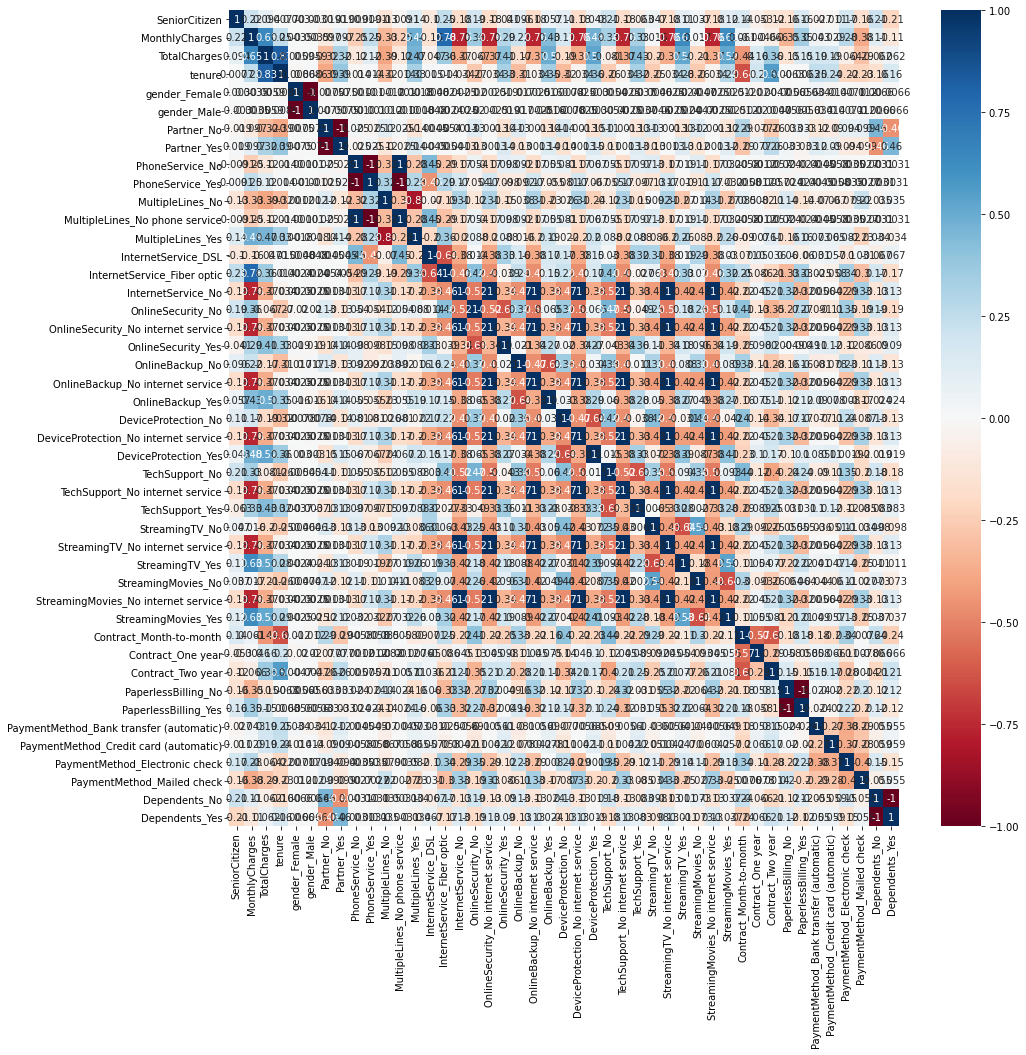

In [209]:
plt.figure(figsize=(15,15))
sns.heatmap(X.corr(), cmap='RdBu', vmax=1, vmin=-1, annot=True)

In [210]:
corr_matrix = X.corr()
cols = corr_matrix.columns
corr_matrix.reset_index(inplace=True)
corr_matrix = corr_matrix.melt(id_vars='index', value_vars=cols)
print(corr_matrix.shape)
corr_matrix.head()

(2025, 3)


,index,variable,value
0,SeniorCitizen,SeniorCitizen,1.000000
1,MonthlyCharges,SeniorCitizen,0.215351
2,TotalCharges,SeniorCitizen,0.093518
3,tenure,SeniorCitizen,0.007730
4,gender_Female,SeniorCitizen,0.002990


In [211]:
corr_matrix = corr_matrix[corr_matrix['index']!=corr_matrix['variable']]
corr_matrix = corr_matrix[corr_matrix['value'].abs()>.8]

cols_to_drop = set(corr_matrix['index'].values.tolist())
cols_to_drop

{'Dependents_No',
 'Dependents_Yes',
 'DeviceProtection_No internet service',
 'InternetService_No',
 'MultipleLines_No',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'OnlineBackup_No internet service',
 'OnlineSecurity_No internet service',
 'PaperlessBilling_No',
 'PaperlessBilling_Yes',
 'Partner_No',
 'Partner_Yes',
 'PhoneService_No',
 'PhoneService_Yes',
 'StreamingMovies_No internet service',
 'StreamingTV_No internet service',
 'TechSupport_No internet service',
 'TotalCharges',
 'gender_Female',
 'gender_Male',
 'tenure'}

In [212]:
cols_to_drop.remove('InternetService_No')
cols_to_drop.remove('PhoneService_Yes')
cols_to_drop.remove('PhoneService_No')
cols_to_drop.remove('Dependents_Yes')
cols_to_drop.remove('Dependents_No')
cols_to_drop.remove('MultipleLines_Yes')
cols_to_drop.remove('MultipleLines_No')
cols_to_drop.remove('PaperlessBilling_Yes')
cols_to_drop.remove('PaperlessBilling_No')
cols_to_drop.remove('Partner_Yes')
cols_to_drop.remove('Partner_No')
cols_to_drop.remove('gender_Female')
cols_to_drop.remove('gender_Male')
cols_to_drop.remove('tenure')
cols_to_drop.remove('TotalCharges')
X = X.drop(columns=cols_to_drop)
print(X.shape)
X.head()

(5634, 38)


,SeniorCitizen,MonthlyCharges,TotalCharges,tenure,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Dependents_No,Dependents_Yes
0,0,45.05,2560.10,56.00,1,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,1,0,0,0,1,1,0,0,0,0,1,1,0
1,0,19.65,332.65,15.97,0,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1
2,0,110.80,6640.70,60.00,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0
3,0,101.90,3545.35,37.00,1,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,1,1,0,0,0,1,0
4,0,70.75,1974.80,29.00,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1


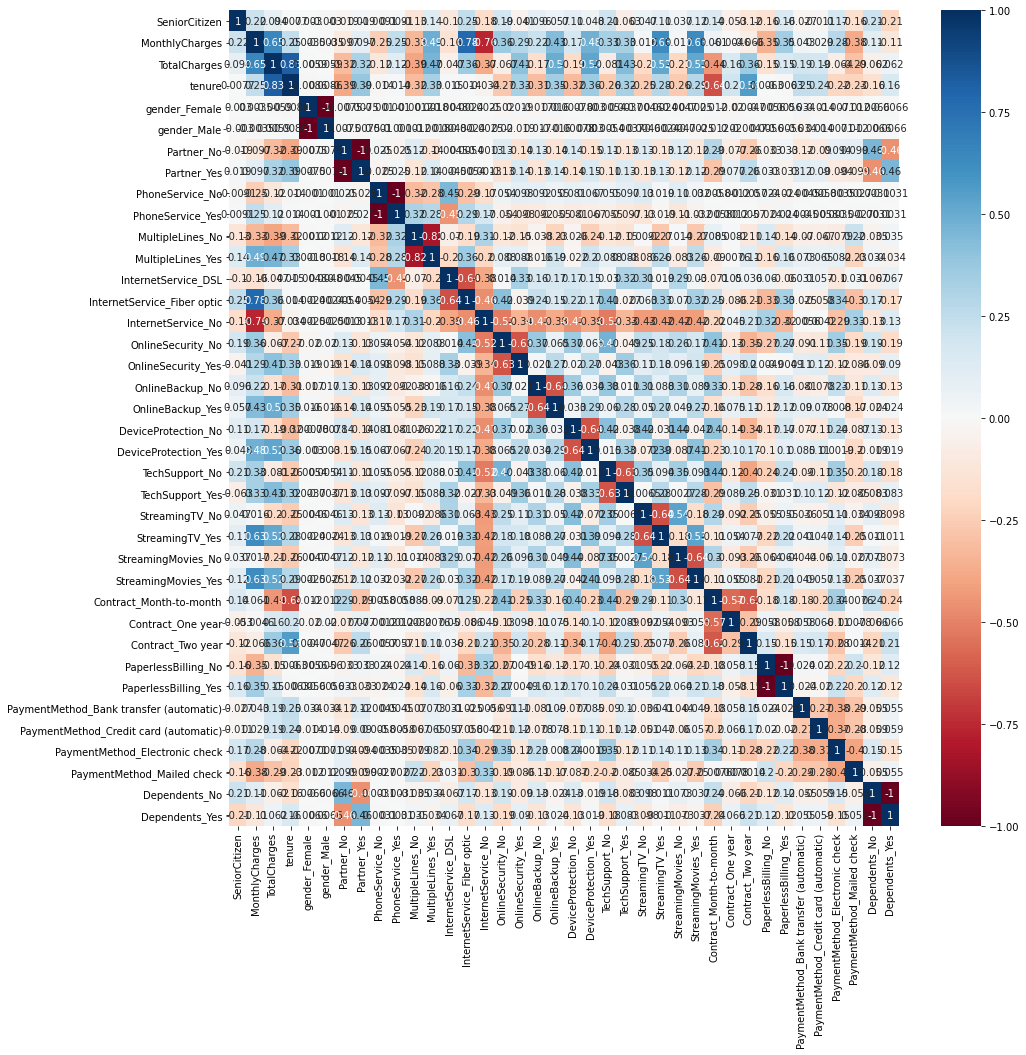

In [213]:
plt.figure(figsize=(15,15))
sns.heatmap(X.corr(), cmap='RdBu', vmax=1, vmin=-1, annot=True)

## X_train, Y_train

In [214]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape

((4507, 38), (1127, 38))

# XGBoost Tuning

## General approach

---

1. Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems
2. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required
3. Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree 
4. Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance
5. Lower the learning rate and decide the optimal parameters

---

## Func to create XGBoost models and perform cross-validation

In [217]:
def modelfit(alg, Xtrain=X_train, Ytrain=Y_train, Xtest=X_test, Ytest=Y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(Xtrain.values, label=Ytrain.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(Xtrain, Ytrain, eval_metric='auc')
        
    #Predict training set:
    dtrain_predprob_train = alg.predict_proba(Xtrain)[:,1]
    dtrain_predprob_test = alg.predict_proba(Xtest)[:,1]
    
    #print model parameter:
    print('n_estimators: ', alg.get_params()['n_estimators'])
    #Print model report:
    print("\nModel Report")
    print("Accuracy (Train): {:.5}".format(alg.score(Xtrain, Ytrain)))
    print("AUC Score (Train): {:.5}".format(roc_auc_score(Ytrain, dtrain_predprob_train)))
    print("Accuracy (Test): {:.5}".format(alg.score(Xtest, Ytest)))
    print("AUC Score (Test): {:.5}".format(roc_auc_score(Ytest, dtrain_predprob_test)))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## n-estimators, learning_rate



---

In order to decide on boosting parameters, we need to set some initial values of other parameters.  They all will anyways be tuned later.

* `max_depth=5`: this should be between 3-10 (4-6 is a good starting point)
* `min_child_weight=1`: smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups
* `gamma=0`: smaller value like 0.1-0.2 can also be chosen for starting.
* `subsample, colsample_bytree=0.8`: commonly used start value. Typical values range between 0.5-0.9.
* `scale_pos_weight=1`: because of high class imbalance

---



n_estimators:  19

Model Report
Accuracy (Train): 0.83093
AUC Score (Train): 0.8885
Accuracy (Test): 0.79414
AUC Score (Test): 0.82937


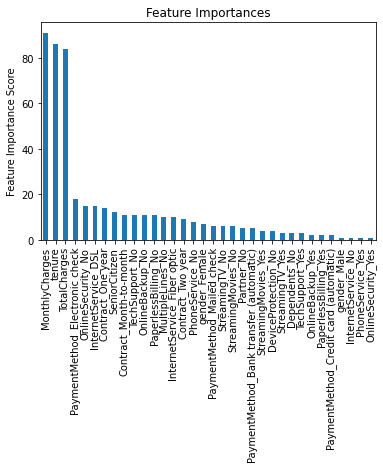

In [218]:
xgb1 = XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1, objective='binary:logistic', nthread=4, seed=2)
modelfit(xgb1)

In [ ]:
xgb1 = XGBClassifier(n_estimators=27, learning_rate=0.1, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1, objective='binary:logistic', nthread=4, seed=2)
xgb1.fit(X_train, Y_train)
print('Accuracy: ', xgb1.score(X_test, Y_test))
print('AUC: ', roc_auc_score(Y_test, pd.DataFrame(xgb1.predict_proba(X_test)[:,1])))

Accuracy:  0.8092280390417036
AUC:  0.8512484615446494


## max_depth, min_child_weight

In [ ]:
xgb_gs = GridSearchCV(estimator=XGBClassifier(n_estimators=27, learning_rate=0.1, gamma=0, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1, objective='binary:logistic', nthread=4, seed=2), 
                      param_grid={'max_depth':list(range(3,10)), 'min_child_weight':list(range(8,12))}, cv=10, scoring='roc_auc', iid=False, n_jobs=-1)
xgb_gs.fit(X_train, Y_train)
print('Best params: ', xgb_gs.best_params_, '\nBest score: ', xgb_gs.best_score_)

Best params:  {'max_depth': 5, 'min_child_weight': 9} 
Best score:  0.8533382141758535


In [ ]:
xgb1 = XGBClassifier(n_estimators=27, learning_rate=0.1, max_depth=5, min_child_weight=9, gamma=0, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1, objective='binary:logistic', nthread=4, seed=2)
xgb1.fit(X_train, Y_train)
print('Accuracy: ', xgb1.score(X_test, Y_test))
print('AUC: ', roc_auc_score(Y_test, pd.DataFrame(xgb1.predict_proba(X_test)[:,1])))

Accuracy:  0.808340727595386
AUC:  0.8536215037848012


## gamma

In [ ]:
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
xgb_gs = GridSearchCV(estimator=XGBClassifier(n_estimator=27, learning_rate=0.1, max_depth=5, min_child_weight=9, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1, objective='binary:logistic', nthread=4, seed=2), 
                      param_grid={'gamma':[i/10 for i in range(0,10)]}, cv=10, scoring='roc_auc', iid=False, n_jobs=-1)
xgb_gs.fit(X_train, Y_train)
print('Best params: ', xgb_gs.best_params_, '\nBest score: ', xgb_gs.best_score_)

Best params:  {'gamma': 0.5} 
Best score:  0.8502257462152043


In [ ]:
xgb1 = XGBClassifier(n_estimators=27, learning_rate=0.1, max_depth=5, min_child_weight=9, gamma=0.5, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1, objective='binary:logistic', nthread=4, seed=2)
xgb1.fit(X_train, Y_train)
print('Accuracy: ', xgb1.score(X_test, Y_test))
print('AUC: ', roc_auc_score(Y_test, pd.DataFrame(xgb1.predict_proba(X_test)[:,1])))

Accuracy:  0.8101153504880213
AUC:  0.8532896800817291


## Re-calibrate the number of boosting rounds for the updated parameters

n_estimators:  42

Model Report
Accuracy (Train): 0.83537
AUC Score (Train): 0.8938
Accuracy (Test): 0.80568
AUC Score (Test): 0.85301


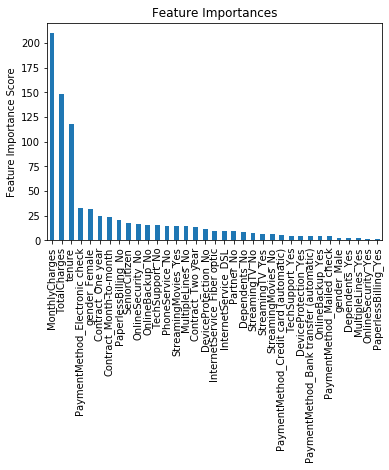

In [ ]:
xgb1 = XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=5, min_child_weight=9, gamma=0.5, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1, objective='binary:logistic', nthread=4, seed=2)
modelfit(xgb1)

## subsample, colsample_bytree

In [ ]:
xgb_gs = GridSearchCV(estimator=XGBClassifier(n_estimator=42, learning_rate=0.1, max_depth=5, min_child_weight=9, gamma=0.5, scale_pos_weight=1, objective='binary:logistic', nthread=4, seed=2), 
                      param_grid={'subsample':[i/10 for i in range(6,11)], 'colsample_bytree':[i/10 for i in range(2,6)]}, cv=10, scoring='roc_auc', n_jobs=-1)
xgb_gs.fit(X_train, Y_train)
print('Best params: ', xgb_gs.best_params_, '\nBest score: ', xgb_gs.best_score_)

Best params:  {'colsample_bytree': 0.4, 'subsample': 1.0} 
Best score:  0.8523128233637627


In [ ]:
xgb1 = XGBClassifier(n_estimators=42, learning_rate=0.1, max_depth=5, min_child_weight=9, gamma=0.5, subsample=1.0, colsample_bytree=0.4, scale_pos_weight=1, objective='binary:logistic', nthread=4, seed=2)
xgb1.fit(X_train, Y_train)
print('Accuracy: ', xgb1.score(X_test, Y_test))
print('AUC: ', roc_auc_score(Y_test, pd.DataFrame(xgb1.predict_proba(X_test)[:,1])))

Accuracy:  0.8101153504880213
AUC:  0.8520548936957519


## regularization parameters

In [ ]:
xgb_gs = GridSearchCV(estimator=XGBClassifier(n_estimator=42, learning_rate=0.1, max_depth=5, min_child_weight=9, gamma=0.5, subsample=1.0, colsample_bytree=0.4, scale_pos_weight=1, objective='binary:logistic', nthread=4, seed=2), 
                      param_grid={'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10, 100]}, cv=10, scoring='roc_auc', n_jobs=-1)
xgb_gs.fit(X_train, Y_train)
print('Best params: ', xgb_gs.best_params_, '\nBest score: ', xgb_gs.best_score_)

Best params:  {'reg_alpha': 10} 
Best score:  0.8534637096894974


In [ ]:
xgb_gs = GridSearchCV(estimator=XGBClassifier(n_estimator=42, learning_rate=0.1, max_depth=5, min_child_weight=9, gamma=0.5, subsample=1.0, colsample_bytree=0.4, scale_pos_weight=1, objective='binary:logistic', nthread=4, seed=2), 
                      param_grid={'reg_alpha':[0, 5, 10, 50, 100]}, cv=10, scoring='roc_auc', n_jobs=-1)
xgb_gs.fit(X_train, Y_train)
print('Best params: ', xgb_gs.best_params_, '\nBest score: ', xgb_gs.best_score_)

Best params:  {'reg_alpha': 10} 
Best score:  0.8534637096894974


In [ ]:
xgb1 = XGBClassifier(n_estimators=42, learning_rate=0.1, max_depth=5, min_child_weight=9, gamma=0.5, subsample=1.0, colsample_bytree=0.4, scale_pos_weight=1, reg_alpha=10, objective='binary:logistic', nthread=4, seed=2)
xgb1.fit(X_train, Y_train)
print('Accuracy: ', xgb1.score(X_test, Y_test))
print('AUC: ', roc_auc_score(Y_test, pd.DataFrame(xgb1.predict_proba(X_test)[:,1])))

Accuracy:  0.808340727595386
AUC:  0.8551780586101212


## Re-calibrate the number of boosting rounds for the updated parameters

n_estimators:  167

Model Report
Accuracy (Train): 0.83204
AUC Score (Train): 0.87846
Accuracy (Test): 0.80745
AUC Score (Test): 0.85366


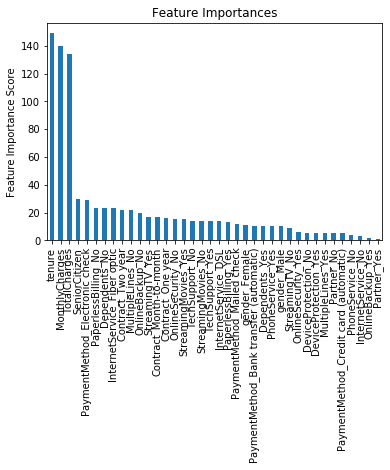

In [ ]:
xgb1 = XGBClassifier(n_estimators=1000, learning_rate=0.1, max_depth=5, min_child_weight=9, gamma=0.5, subsample=1.0, colsample_bytree=0.4, scale_pos_weight=1, reg_alpha=10, objective='binary:logistic', nthread=4, seed=2)
modelfit(xgb1)

## Reducing learning_rate

n_estimators:  842

Model Report
Accuracy (Train): 0.8296
AUC Score (Train): 0.8757
Accuracy (Test): 0.80479
AUC Score (Test): 0.85312


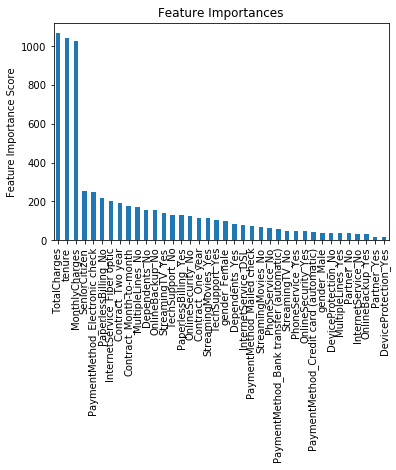

In [ ]:
xgb1 = XGBClassifier(n_estimators=5000, learning_rate=0.01, max_depth=5, min_child_weight=9, gamma=0.5, subsample=1.0, colsample_bytree=0.4, scale_pos_weight=1, reg_alpha=10, objective='binary:logistic', nthread=4, seed=2)
modelfit(xgb1)

## Final Model

In [216]:
xgb1 = XGBClassifier(n_estimators=842, learning_rate=0.01, max_depth=5, min_child_weight=9, gamma=0.5, subsample=1.0, colsample_bytree=0.4, scale_pos_weight=1, reg_alpha=10, objective='binary:logistic', nthread=4, seed=2)
xgb1.fit(X_train, Y_train)
print('Accuracy: ', xgb1.score(X_test, Y_test))
print('AUC: ', roc_auc_score(Y_test, pd.DataFrame(xgb1.predict_proba(X_test)[:,1])))

Accuracy:  0.7994676131322094
AUC:  0.8278414810813465


# Test data

## Feature Selection for the model

In [219]:
test_cat_cols = df_test.columns[df_test.dtypes=='object']
test_num_cols = X_train.columns[X_train.dtypes!='uint8']

#get dummies on categorical values
test_dummies = pd.get_dummies(data = df_test, columns=test_cat_cols, drop_first=False)
test_dummies = test_dummies.drop(columns=test_num_cols)

#create col of zeros which is doesn't exist in the test data, but which is need for the model 
#test_dummies['GarageQual_Fa'] = np.zeros(len(test_dummies))

#leave just dummies used in the model
test_dummies = test_dummies[X.columns[X.dtypes=='uint8']]

print(test_dummies.shape)
test_dummies.head()

(1409, 34)


,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Dependents_No,Dependents_Yes
0,0,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1
1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1
2,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0
3,1,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,0,0,1
4,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0


In [220]:
X_result = pd.concat([df_test[test_num_cols], test_dummies], axis=1)
print(X_result.shape)
X_result.head()

(1409, 38)


,SeniorCitizen,MonthlyCharges,TotalCharges,tenure,gender_Female,gender_Male,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Dependents_No,Dependents_Yes
0,0,20.00,445.30,23.0,0,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1
1,1,99.00,5969.30,61.0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1
2,0,84.75,3050.15,36.0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0
3,0,61.45,3751.15,61.0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,0,0,1
4,0,20.55,945.70,47.0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0


## Missing Values

In [223]:
X_result.isna().sum()

SeniorCitizen                              0
MonthlyCharges                             0
TotalCharges                               0
tenure                                     0
gender_Female                              0
gender_Male                                0
Partner_No                                 0
Partner_Yes                                0
PhoneService_No                            0
PhoneService_Yes                           0
MultipleLines_No                           0
MultipleLines_Yes                          0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
OnlineSecurity_No                          0
OnlineSecurity_Yes                         0
OnlineBackup_No                            0
OnlineBackup_Yes                           0
DeviceProtection_No                        0
DeviceProtection_Yes                       0
TechSupport_No                             0
TechSuppor

## Prediction

In [226]:
result['Churn'] = xgb1.predict(X_result)
print(result.shape)
result.head()

(1409, 2)


,id,Churn
0,5027,0
1,1733,0
2,5384,0
3,6554,0
4,364,0


In [227]:
result.to_csv('result.csv')